In [11]:
import random
import io
import csv

from clkhash.field_formats import *
from clkhash.schema import Schema
from clkhash.comparators import NgramComparison, ExactComparison, NumericComparison
from clkhash.clk import generate_clk_from_csv

## Exact Comparison

The exact comparison technique creates high similarity scores if inputs are identical, and low otherwise. This can be useful when comparing data like credit card numbers or email addresses. It is a good choise whenever data is either an exact match or has no similarity at all. 
The main advantage of the *Exact Comparison* technique is that it better separates the similarity scores of the matches from the non-matches (but cannot acount for errors).

We will show this with the following experiment. First, we create a dataset consisting of random 6-digit numbers. Then compare the dataset with itself once encoded with the *Exact Comparison*, and twice encoded with the *Ngram Comparison* (uni- and bi-grams) technique.

In [81]:
data = [[i, random.randrange(1000000)] for i in range(5000)]
a_csv = io.StringIO()
csv.writer(a_csv).writerows(data_A)

We define three different schemas, one for each comparison technique.

In [82]:
fields = [
    Ignore('rec_id'),
    IntegerSpec('random', FieldHashingProperties(comparator=NgramComparison(1, True), strategy=BitsPerFeatureStrategy(300))),
]
unigram_schema = Schema(fields, 512)


fields = [
    Ignore('rec_id'),
    IntegerSpec('random', FieldHashingProperties(comparator=NgramComparison(2, True), strategy=BitsPerFeatureStrategy(300))),
]
bigram_schema = Schema(fields, 512)


fields = [
    Ignore('rec_id'),
    IntegerSpec('random', FieldHashingProperties(comparator=ExactComparison(), strategy=BitsPerFeatureStrategy(300))),
]

exact_schema = Schema(fields, 512)


secret_key = 'password1234'

In [83]:
from bitarray import bitarray
import base64
import anonlink

def deserialize_bitarray(bytes_data):
    ba = bitarray(endian='big')
    data_as_bytes = base64.decodebytes(bytes_data.encode())
    ba.frombytes(data_as_bytes)
    return ba

def deserialize_filters(filters):
    res = []
    for i, f in enumerate(filters):
        ba = deserialize_bitarray(f)
        res.append(ba)
    return res

def sim_scores_from_clks(clks_a, clks_b, threshold):
    results_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
            [clks_a, clks_b],
            anonlink.similarities.dice_coefficient,
            threshold
    )
    return results_candidate_pairs[0]

generate the CLKs according to the three different schemas.

In [84]:
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, unigram_schema, header=False)
clks_a_unigram = deserialize_filters(hashed_data_a)
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, bigram_schema, header=False)
clks_a_bigram = deserialize_filters(hashed_data_a)
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, exact_schema, header=False)
clks_a_exact = deserialize_filters(hashed_data_a)

generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 13.1kclk/s, mean=229, std=5.88]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 13.1kclk/s, mean=228, std=5.87]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 15.0kclk/s, mean=227, std=5.75]


We do an exhaustive pairwise comparison for the CLKs and keep the similarities above 0.5.

In [85]:
sim_scores_unigram = sim_scores_from_clks(clks_a_unigram, clks_a_unigram, 0.5)
sim_scores_bigram = sim_scores_from_clks(clks_a_bigram, clks_a_bigram, 0.5)
sim_scores_exact = sim_scores_from_clks(clks_a_exact, clks_a_exact, 0.5)

We will plot the similarity scores as histograms. Note that the y-axis is in log scale.

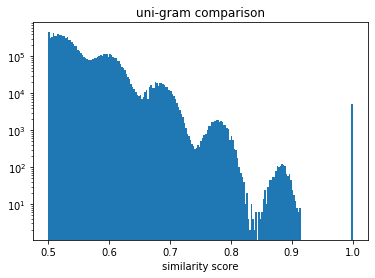

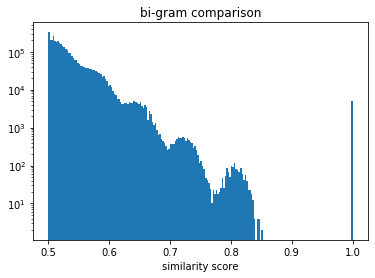

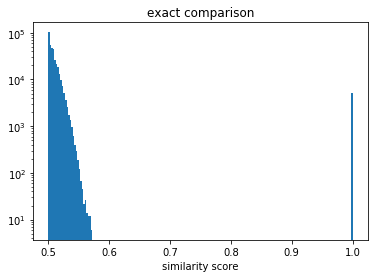

In [92]:
import matplotlib.pyplot as plt
plt.hist(sim_scores_unigram, bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('uni-gram comparison')
plt.show()
plt.hist(sim_scores_bigram, bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('bi-gram comparison')
plt.show()
plt.hist(sim_scores_exact, bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('exact comparison')
plt.show()

The true matches all lie on the vertical line above the 1.0. We can see that the *Exact Comparison* technique significantly widens the gap between matches and non-matches. The better the separation between matches and non-matches, the easier it will be for the solver to find the correct linkage.

### Numeric Comparison
This technique enables numerical comparisons of integers or floating point numbers.

Comparing numbers creates an interesting challenge. The pairs (1000, 1001) and (1000, 999) are equally similiar. String-based techniques like n-gram comparison will produce unexpected results, as the first pair has three digits in common, compared to none in the last pair. 

We have implemented a technique, where the numerical distance between two numbers relate to the similarity of the tokens produces.

We generate a dataset with one column of random 7-digit integers, and a second dataset where we alter the integers of the first dataset by +/- 50. 

In [116]:
data_A = [[i, random.randrange(10000000)] for i in range(5000)]
data_B = [[i, x + random.randint(-50,50)] for i,x in data_A]

In [117]:
a_csv = io.StringIO()
b_csv = io.StringIO()
csv.writer(a_csv).writerows(data_A)
csv.writer(b_csv).writerows(data_B)

We define two linkage schemas, one for postitional uni-gram comparison and one for numeric comparison.

In [208]:
fields = [
    Ignore('rec_id'),
    IntegerSpec('random', 
                FieldHashingProperties(comparator=NgramComparison(1, True), 
                                       strategy=BitsPerFeatureStrategy(301))),
]
unigram_schema = Schema(fields, 512)

fields = [
    Ignore('rec_id'),
    IntegerSpec('random', 
                FieldHashingProperties(comparator=NumericComparison(threshold_distance=100, resolution=150),
                                       strategy=BitsPerFeatureStrategy(301))),
]
numeric_schema = Schema(fields, 512)

secret_key = 'password1234'

In [200]:
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, unigram_schema, header=False)
clks_a_unigram = deserialize_filters(hashed_data_a)
b_csv.seek(0)
hashed_data_b = generate_clk_from_csv(b_csv, secret_key, unigram_schema, header=False)
clks_b_unigram = deserialize_filters(hashed_data_b)
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, numeric_schema, header=False)
clks_a_numeric = deserialize_filters(hashed_data_a)
b_csv.seek(0)
hashed_data_b = generate_clk_from_csv(b_csv, secret_key, numeric_schema, header=False)
clks_b_numeric = deserialize_filters(hashed_data_b)

generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 12.0kclk/s, mean=229, std=5.97]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 12.1kclk/s, mean=229, std=5.93]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:02<00:00, 1.35kclk/s, mean=228, std=5.94]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:02<00:00, 1.51kclk/s, mean=228, std=5.87]


First, we will look at the similarity score distributions.

In [201]:
sim_scores_unigram = sim_scores_from_clks(clks_a_unigram, clks_b_unigram, 0.5)
sim_scores_numeric = sim_scores_from_clks(clks_a_numeric, clks_b_numeric, 0.5)

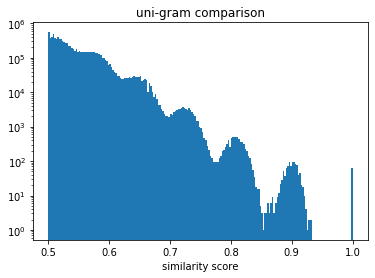

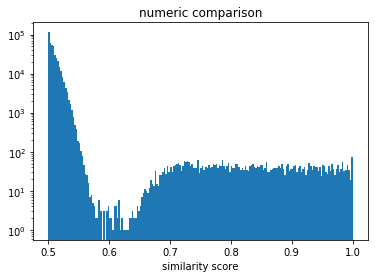

In [202]:
import matplotlib.pyplot as plt
plt.hist(sim_scores_unigram, bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('uni-gram comparison')
plt.show()
plt.hist(sim_scores_numeric, bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('numeric comparison')
plt.show()


The distribution for the numeric comparison is very different to the uni-gram one. We can see a plateau between 0.7 and 1.0. These are mainly the scores for the true matches. And as we 

In [130]:
def mapping_from_clks(clks_a, clks_b, threshold):
    results_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
            [clks_a, clks_b],
            anonlink.similarities.dice_coefficient,
            threshold
    )
    solution = anonlink.solving.greedy_solve(results_candidate_pairs)
    print('Found {} matches'.format(len(solution)))
    return {a:b for ((_, a),(_, b)) in solution}

In [131]:
a_csv.seek(0)
b_csv.seek(0)
a_raw = a_csv.readlines()
b_raw = b_csv.readlines()

num_entities = len(b_raw) - 1
  
def describe_matching_quality(mapping):
 
    TP = 0; FP = 0; TN = 0; FN = 0
    for a_i in range(num_entities):
        if a_i in mapping:
            if a_raw[a_i].split(',')[0] == b_raw[mapping[a_i]].split(',')[0]:
                TP += 1
            else:
                FP += 1
                # as we only report one mapping for each element in PII_a, 
                # then a wrong mapping is not only a false positive, but 
                # also a false negative, as we won't report the true mapping.
                FN += 1 
        else:
            FN += 1 # every element in PII_a has a partner in PII_b

    print()
    print("We've got {} true positives, {} false positives, and {} false negatives.".format(TP, FP, FN))
    print('Precision: {:.3f}, Recall: {:.3f}, Accuracy: {:.3f}'.format(
        TP/(TP+FP), 
        TP/(TP+FN), 
        (TP+TN)/(TP+TN+FP+FN)))

In [203]:
numeric_mapping = mapping_from_clks(clks_a_numeric, clks_b_numeric, 0.7)

Found 4615 matches


In [204]:
describe_accuracy(numeric_mapping, show_examples=True)

idx_a, idx_b,     rec_id_a,       rec_id_b
---------------------------------------------
  0,      0,               0,               0
  1,      1,               1,               1
  2,      2,               2,               2
  5,      5,               5,               5
  6,      6,               6,               6
  7,      7,               7,               7
  8,      8,               8,               8
  9,      9,               9,               9
---------------------------------------------

We've got 4509 true positives, 99 false positives, and 490 false negatives.
Precision: 0.979, Recall: 0.902, Accuracy: 0.884


In [205]:
ngram_mapping = mapping_from_clks(clks_a_unigram, clks_b_unigram, 0.7)

Found 4705 matches


In [206]:
describe_accuracy(ngram_mapping, show_examples=True)

idx_a, idx_b,     rec_id_a,       rec_id_b
---------------------------------------------
  0,   1599,               0,            1599
  1,      1,               1,               1
  2,      2,               2,               2
  3,      3,               3,               3
  4,      4,               4,               4
  6,      6,               6,               6
  7,      7,               7,               7
  8,      8,               8,               8
  9,   4255,               9,            4255
---------------------------------------------

We've got 2833 true positives, 1736 false positives, and 2166 false negatives.
Precision: 0.620, Recall: 0.567, Accuracy: 0.421


(array([62., 41., 48., 47., 48., 38., 54., 48., 52., 40., 47., 48., 53.,
        58., 55., 44., 47., 49., 46., 53., 67., 46., 49., 38., 43., 37.,
        55., 59., 48., 50., 51., 43., 43., 52., 66., 66., 39., 66., 45.,
        46., 45., 65., 65., 55., 48., 46., 43., 55., 72., 51., 54., 48.,
        38., 48., 36., 57., 61., 62., 48., 44., 52., 53., 51., 47., 47.,
        52., 46., 52., 53., 46., 54., 38., 51., 50., 43., 40., 47., 48.,
        44., 60., 38., 45., 47., 53., 51., 60., 50., 50., 60., 55., 49.,
        45., 56., 43., 40., 59., 58., 44., 47., 48.]),
 array([1.47200000e+03, 1.01426640e+05, 2.01381280e+05, 3.01335920e+05,
        4.01290560e+05, 5.01245200e+05, 6.01199840e+05, 7.01154480e+05,
        8.01109120e+05, 9.01063760e+05, 1.00101840e+06, 1.10097304e+06,
        1.20092768e+06, 1.30088232e+06, 1.40083696e+06, 1.50079160e+06,
        1.60074624e+06, 1.70070088e+06, 1.80065552e+06, 1.90061016e+06,
        2.00056480e+06, 2.10051944e+06, 2.20047408e+06, 2.30042872e+06,
  

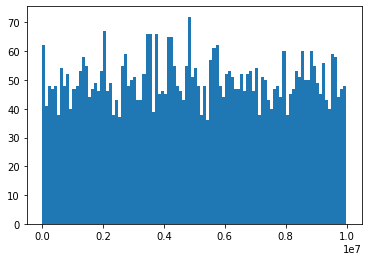

In [207]:
plt.hist([x for (_, x) in data_A], bins=100)

In [243]:
def sim_scores_from_clks2(clks_a, clks_b, threshold):
    results_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
            [clks_a, clks_b],
            anonlink.similarities.dice_coefficient,
            threshold
    )
    for i, idx in enumerate(results_candidate_pairs[2]):
        print(idx)
    return results_candidate_pairs

In [244]:
x = sim_scores_from_clks2(clks_a_numeric, clks_b_numeric, 0.9)

array('I', [44, 61, 85, 208, 210, 474, 494, 816, 846, 867, 914, 922, 948, 975, 1022, 1113, 1146, 1232, 1374, 1436, 1465, 1593, 1681, 1767, 1877, 1990, 2034, 2056, 2101, 2166, 2200, 2255, 2317, 2322, 2513, 2536, 2695, 2727, 2810, 2815, 3252, 3286, 3338, 3484, 3575, 3633, 3661, 3755, 3840, 3935, 4041, 4141, 4177, 4226, 4334, 4388, 4417, 4458, 4468, 4524, 4631, 4661, 4765, 4767, 4883, 4945, 933, 2754, 1738, 4876, 509, 831, 1825, 4758, 3323, 666, 916, 2442, 1516, 2400, 484, 811, 1389, 2919, 2121, 2849, 1099, 4724, 4964, 1199, 2665, 2851, 3874, 2405, 27, 1227, 1951, 2805, 805, 1547, 2467, 2671, 1765, 1901, 2261, 3162, 134, 3728, 2357, 3678, 4896, 4942, 3364, 4369, 1553, 472, 4974, 348, 1475, 4323, 4795, 3396, 594, 3504, 4107, 1398, 2008, 3887, 2882, 2655, 4537, 1073, 1203, 1852, 4969, 2316, 4334, 4345, 4484, 1717, 1760, 2854, 2104, 2710, 4420, 65, 432, 3619, 4466, 190, 845, 1287, 1525, 3656, 783, 1597, 3020, 4509, 3306, 3900, 719, 2497, 2515, 3566, 3695, 1074, 1840, 2786, 3853, 2706, 4877, 

In [241]:
def na(x):
    for a in zip(*x):
        print(f'asdfa: {a}')
    pass

In [242]:
na(x)

asdfa: (1.0, array('I', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [246]:
len(x[2])

2